 # Shelter Animal Outcome - Udacity MLND Capstone Project




## Overview
Each year millions of dogs and cats enter animal shelters across the U.S. Approximately 3.2 million shelter animals are adopted each year. Therefore, the task of predicting animals’ outcomes can gain useful insights to the shelter’s trends and help animals find families to take them home. Recognizing animal outcomes beforehand may shape shelter policy. Shelters can focus their energy on specific animals that need a bit more help to find their new home and utilize their resources effectively.

We can perform such task by applying machine learning, especially supervised classification, on a dataset from Austin Animal Center (via <a href=https://www.kaggle.com/c/shelter-animal-outcomes>Kaggle Competition</a>). The animal shelter dataset represent the status of animals as they enter and leave the Animal Center.

The objective of this project is to predict if an animal is going to be <b>adopted, died, euthanized, returned to owner or transferred</b>. The metric is multi-class logarithmic loss, the multi-class version of the Logarithmic Loss metric.

### Outline
-	Research Kaggle animal competition and analyze the data leak feature problems
-	Obtain datasets from Austin animal shelters website and perform dataset merging
-	Feature engineering and preprocessing
-	Exploratory Data Analysis (EDA)
-	Supervised models comparisons
-	Hyper parameter tuning
-   Stacking Ensemble

## Step 1: Data leak issues, merging two datasets and preprocessing

In [1]:
#import neccessary modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.dummy import DummyClassifier
%matplotlib inline
%timeit

Two datasets (Outcome dataset and Intake dataset) can be found in Austin Shelter official website <a href = https://data.austintexas.gov/browse?q=austin%20animal%20center&sortBy=relevance&utf8=%E2%9C%93>here</a> 

The reasons 2 datasets are used can be found in __Data Leak__ session


Intake dataset contains animals information upon intake, and Outcome dataset contains information upon outcome

In [2]:
dataoutcome = pd.read_csv('Austin_Animal_Center_Outcomes.csv').drop_duplicates()
dataintake = pd.read_csv('Austin_Animal_Center_Intakes.csv').drop_duplicates()
# print(dataoutcome.columns)
print(dataoutcome.head())
print('-'*100)
# print(dataintake.columns)
print(dataintake.head())

  Animal ID          Name                DateTime               MonthYear  \
0   A741715      *Pebbles  01/11/2017 06:17:00 PM  01/11/2017 06:17:00 PM   
1   A658751         Benji  11/13/2016 01:38:00 PM  11/13/2016 01:38:00 PM   
2   A721285           NaN  02/24/2016 02:42:00 PM  02/24/2016 02:42:00 PM   
3   A746650          Rose  04/07/2017 11:58:00 AM  04/07/2017 11:58:00 AM   
4   A750122  Happy Camper  05/24/2017 06:36:00 PM  05/24/2017 06:36:00 PM   

  Date of Birth     Outcome Type Outcome Subtype Animal Type Sex upon Outcome  \
0    03/07/2016         Adoption             NaN         Cat    Spayed Female   
1    07/14/2011  Return to Owner             NaN         Dog    Neutered Male   
2    02/24/2014       Euthanasia       Suffering       Other          Unknown   
3    04/06/2016  Return to Owner             NaN         Dog    Intact Female   
4    04/08/2017         Transfer         Partner         Dog      Intact Male   

  Age upon Outcome                                

In [3]:
#drop all animal type that is not dog or cat
dataoutcome.drop(dataoutcome[dataoutcome['Animal Type'].isin(['Other','Bird','Livestock'])].index,inplace=True)
dataintake.drop(dataintake[dataintake['Animal Type'].isin(['Other','Bird','Livestock'])].index,inplace=True)


#drop unnecessary columns
dataintake.drop('Found Location',axis=1,inplace=True) # drop address
dataintake.drop('MonthYear',axis=1,inplace=True) #duplicate with datetime
dataoutcome.drop('MonthYear',axis=1,inplace=True) #duplicate with datetime
dataoutcome.drop('Date of Birth',axis=1,inplace=True) # there is already an 'age' attribute.
dataoutcome.drop('Outcome Subtype',axis=1,inplace=True) # Redundant

dataintake['DateTime'] = pd.to_datetime(dataintake.DateTime)
dataoutcome['DateTime'] = pd.to_datetime(dataoutcome.DateTime)


### Missing data

In [4]:
# calculate % missing data
def missing_percentage(df): 
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data.head(20))

missing_percentage(dataintake)
missing_percentage(dataoutcome)



                  Total   Percent
Name              17658  0.270936
Sex upon Intake       1  0.000015
Color                 0  0.000000
Breed                 0  0.000000
Age upon Intake       0  0.000000
Animal Type           0  0.000000
Intake Condition      0  0.000000
Intake Type           0  0.000000
DateTime              0  0.000000
Animal ID             0  0.000000
                  Total   Percent
Name              17530  0.269485
Outcome Type          3  0.000046
Sex upon Outcome      2  0.000031
Age upon Outcome      1  0.000015
Color                 0  0.000000
Breed                 0  0.000000
Animal Type           0  0.000000
DateTime              0  0.000000
Animal ID             0  0.000000


Fortunately, both datasets do not contain many missing values, except for name. Around 26%-27% records from both sets have missing names.  

In [5]:
#drop animals that don't have outcome type, sex upon outcome, age upon outcome and sex upon intake
cols_outcome=['Outcome Type','Sex upon Outcome','Age upon Outcome']
col_intake='Sex upon Intake'

for each in cols_outcome:
    dataoutcome.drop(dataoutcome[dataoutcome[each].isnull() == True].index,inplace=True)
    
dataintake.drop(dataintake[dataintake[col_intake].isnull() == True].index,inplace=True)


In [6]:
print (dataoutcome.columns)
print (dataintake.columns)
print ('outcome size: {}'.format(dataoutcome.shape[0]))
print ('intake size: {}'.format(dataintake.shape[0]))

Index(['Animal ID', 'Name', 'DateTime', 'Outcome Type', 'Animal Type',
       'Sex upon Outcome', 'Age upon Outcome', 'Breed', 'Color'],
      dtype='object')
Index(['Animal ID', 'Name', 'DateTime', 'Intake Type', 'Intake Condition',
       'Animal Type', 'Sex upon Intake', 'Age upon Intake', 'Breed', 'Color'],
      dtype='object')
outcome size: 65046
intake size: 65173


### Data leak

There is an issue with this dataset, especially the 'Outcome' dataset. Features such as <b>Datetime of outcome, Age upon outcome and Sex upon Outcome</b> are achieved when outcome is already determined. Even though these features can be included to make better prediction, any models using these features are useless in real life. The Kaggle competition only uses the 'Outcome' set and top 5 highest scores on this competition leaderboard exploited <b>DateTime</b> upon outcome attribute to get better log loss score. For example, Transfer type can be reliably predicted this way since when animals get transferred, they will leave exactly at the same time. Using this leak, an extreme score of 0.0 can be achieved. More information about the data leak can be found in this <a href='https://www.kaggle.com/c/shelter-animal-outcomes/discussion/22119'>Kaggle discussion</a>

Therefore, I decide to exclude these features, and replaces them with the same features but taken from 'Intake' dataset.

### Merging datasets

Since there are animals are in the intake data but not in the outcome data and vice versa, an inner join merge will be performed using Animal ID. There are some animals with several entries in the intake data and outcome data because they return to the shelter several times. Because of this, a feature called ‘Intake Count’ will be generated to count how many times the animals have come back to the shelter.

For the dataset, it’s best to allow only one entry for each animal. For animals with multiple intakes, we will choose the most recent one. For example, this puppy Lucy has 3 intakes, and the most recent one is on 2016-12-18 at 3:53 pm
<>

She has 3 outcomes, with the most recent one is ‘adopted’, on the same day, at 5:25 pm (90 minutes later, which is really fast!)
<>

After merging, this should be her entry in our data:
<>

(DateTime_x is the outcome time, and DateTime_y is the intake time. Lucy’s IntakeCount is 3)
After merging, all columns associated with the Outcome Data are dropped since the same information can be taken from the Intake Data


In [7]:
# adding intake_count for data outcome
# dont run this twice

intake_count = dataoutcome['Animal ID'].value_counts()
intake_df = pd.DataFrame(intake_count).reset_index()
intake_df.columns=['Animal ID','IntakeCount']

dataoutcome = pd.merge(dataoutcome,intake_df,on='Animal ID').drop_duplicates()
print (dataoutcome.shape)
print (dataoutcome.head())

(65046, 10)
  Animal ID          Name            DateTime     Outcome Type Animal Type  \
0   A741715      *Pebbles 2017-01-11 18:17:00         Adoption         Cat   
1   A658751         Benji 2016-11-13 13:38:00  Return to Owner         Dog   
2   A658751         Benji 2016-05-06 16:48:00  Return to Owner         Dog   
3   A746650          Rose 2017-04-07 11:58:00  Return to Owner         Dog   
4   A750122  Happy Camper 2017-05-24 18:36:00         Transfer         Dog   

  Sex upon Outcome Age upon Outcome                                    Breed  \
0    Spayed Female        10 months                   Domestic Shorthair Mix   
1    Neutered Male          5 years                       Border Terrier Mix   
2    Neutered Male          4 years                       Border Terrier Mix   
3    Intact Female           1 year  Labrador Retriever/Jack Russell Terrier   
4      Intact Male          1 month                   Labrador Retriever Mix   

    Color  IntakeCount  
0  Calico    

In [8]:
# merge data from intake and outcome
data = pd.merge(dataoutcome,dataintake,on='Animal ID').drop_duplicates()
data = data.sort_values(by=['Animal ID','DateTime_x','DateTime_y'])
print (data.columns)
print (data.shape)
#datetime_x = datetime outcome, datetime_y = datetime intake

Index(['Animal ID', 'Name_x', 'DateTime_x', 'Outcome Type', 'Animal Type_x',
       'Sex upon Outcome', 'Age upon Outcome', 'Breed_x', 'Color_x',
       'IntakeCount', 'Name_y', 'DateTime_y', 'Intake Type',
       'Intake Condition', 'Animal Type_y', 'Sex upon Intake',
       'Age upon Intake', 'Breed_y', 'Color_y'],
      dtype='object')
(80115, 19)


In [9]:
# get the intake time associated with the outcome time

#get the unique ID from merged data
unique_count_dict = data['Animal ID'].value_counts().to_dict()
for key in unique_count_dict:
    if unique_count_dict[key] >1:
        multi_records = data[data['Animal ID'] == key]
        #get latest datetime outcome
        latest_outcome = (multi_records.iloc[-1])['DateTime_x']
        intake_times = multi_records['DateTime_y']
        #get intake time for this outcome
        last_intake = intake_times[intake_times < latest_outcome].max()
        
        #for this ID, drop all others records that are not having these intake and outcome time
        data.drop(data[(data['Animal ID'] == key) & \
              ((data['DateTime_x'] != latest_outcome) | \
              (data['DateTime_y'] != last_intake))].index, inplace=True)

print ('merged data shape after deleting: {}'.format(data.shape))
print ('# of records should be the same as # of unique id, which is {}'.format(len(unique_count_dict)))

merged data shape after deleting: (58009, 19)
# of records should be the same as # of unique id, which is 58009


In [10]:
#data = data.drop_duplicates()
temp = data['Animal ID'].value_counts()
dup_id = temp[temp == 2].index
data.drop(data[data['Animal ID'] == dup_id[0]].index,inplace=True)

#There is a puppy with 2 intake records with same intake time but different intake type. 
#This is probably an input mistake, so these 2 records will be dropped
data.shape


(58007, 19)

In [11]:

#drop some outcome features such as outcome name (there's already input name), outcome datetime (data leak), 
#animal type, sex upon outcome, age upon outcome, breed,color

dropped_col = ['Name_x','DateTime_x','Animal Type_x','Sex upon Outcome','Age upon Outcome','Breed_x','Color_x']
data.drop(dropped_col,axis=1,inplace=True)

print (data.head())

      Animal ID     Outcome Type  IntakeCount  Name_y          DateTime_y  \
31099   A006100  Return to Owner            2   Scamp 2014-12-19 10:21:00   
68422   A047759         Transfer            1    Oreo 2014-04-02 15:55:00   
13307   A134067  Return to Owner            1  Bandit 2013-11-16 09:02:00   
49414   A141142  Return to Owner            1  Bettie 2013-11-16 14:46:00   
73133   A163459  Return to Owner            1   Sasha 2014-11-14 15:11:00   

           Intake Type Intake Condition Animal Type_y Sex upon Intake  \
31099    Public Assist           Normal           Dog   Neutered Male   
68422  Owner Surrender           Normal           Dog   Neutered Male   
13307    Public Assist          Injured           Dog   Neutered Male   
49414            Stray             Aged           Dog   Spayed Female   
73133            Stray           Normal           Dog   Intact Female   

      Age upon Intake                      Breed_y       Color_y  
31099         7 years         S

In [12]:
# Distribution of class label

print ((data['Outcome Type'].value_counts() / data.shape[0])*100)

Adoption           42.219043
Transfer           34.230352
Return to Owner    17.775441
Euthanasia          4.740807
Died                0.815419
Rto-Adopt           0.108608
Missing             0.065509
Disposal            0.044822
Name: Outcome Type, dtype: float64


In [13]:
processed_data = data.copy()
# rename columns
processed_data.columns = ['AnimalID','OutcomeType','IntakeCount','Name','DateTime','IntakeType','IntakeCond',\
                          'AnimalType','Sex','Age','Breed','Color']

# data.head()
# remove other minor outcome type
print (processed_data.shape)
processed_data.drop(processed_data[processed_data.OutcomeType.isin(['Disposal','Rto-Adopt','Missing','Relocate'])].index,inplace=True)
print (processed_data.shape)

(58007, 12)
(57880, 12)


In [14]:
#save to csv file.
processed_data.to_csv('processed_data.csv',index=False)

## Step 2: Feature Engineering - Generating New Features

Warning: This is a long section, mostly because I graph and analyze almost every features on the dataset. You can jump to Step 3 to see the classification process.

In [2]:
# CHECKPOINT
animal = pd.read_csv('processed_data.csv',encoding='ISO-8859-1') #using utf8 generates an unicode error on my machine...
print (animal.shape)
print (animal.head())


(57880, 12)
  AnimalID      OutcomeType  IntakeCount    Name             DateTime  \
0  A006100  Return to Owner            2   Scamp  2014-12-19 10:21:00   
1  A047759         Transfer            1    Oreo  2014-04-02 15:55:00   
2  A134067  Return to Owner            1  Bandit  2013-11-16 09:02:00   
3  A141142  Return to Owner            1  Bettie  2013-11-16 14:46:00   
4  A163459  Return to Owner            1   Sasha  2014-11-14 15:11:00   

        IntakeType IntakeCond AnimalType            Sex       Age  \
0    Public Assist     Normal        Dog  Neutered Male   7 years   
1  Owner Surrender     Normal        Dog  Neutered Male  10 years   
2    Public Assist    Injured        Dog  Neutered Male  16 years   
3            Stray       Aged        Dog  Spayed Female  15 years   
4            Stray     Normal        Dog  Intact Female  15 years   

                         Breed         Color  
0         Spinone Italiano Mix  Yellow/White  
1                    Dachshund      Tric

In [3]:
print ((animal.OutcomeType.value_counts() / animal.shape[0])*100)


Adoption           42.311679
Transfer           34.305460
Return to Owner    17.814444
Euthanasia          4.751209
Died                0.817208
Name: OutcomeType, dtype: float64


The <b>Breed</b> features contain more than 1000 unique value. Since we are going to perform one-hot encoding on categorical features, this will increase feature space complexity tremendously. 

Breed provides several information about the animal. For example, “Chihuahua Shorthair/Dachshund” implies a cross breed between Chihuahua and Dachshund with short hair. Or “American Bulldog Mix” implies American Bulldog with mix breed and unknown hair length. Thus, I create <b>IsCross</b>, <b>IsMix</b> and <b>HairType</b> feature to address this characteristic

Breeds can be grouped together. One example is Beagle, Dachshund and Bloodhound breed can be grouped into Hound group. Thus, feature <b>BreedGroup</b> is created to scale down the number of breeds. This reduces Breeds to 7 groups for dogs and 2 groups for cats
Some breeds are ‘Miniature’, implying the smaller-size version of the breed, such as Miniature Poodle, Miniature American Shepherd. In order to see if size affects outcome, i create another feature <b>IsMiniature</b>.

Some dog breeds are known to be aggressive, such as Pit Bull, Rottweiler. Some insurance companies don’t provide pet insurance for these breeds . Based on domain knowledge, this breeds are less likely to be adopted. In order to see if this is true, feature <b>IsAgressive</b> is created.

For <b>Color</b> features, there are 467 unique colors recorded. Some animal has 1, 2 and 3 colors on them. Similar to breed, I group these colors into color groups: Light, Dark, Medium, Light/Dark, Dark/Light, Light/Medium, Medium/Light, Dark/Medium, Medium/Dark and Tricolor.

<b>Sex</b> features provide 2 pieces of information about the animal: whether the animal is neutered/spayed or intact, and whether animal is a male or female. Therefore, 2 features are created: <b>Intactness</b> and <b>AnimalSex</b>.

<b>HasName</b> feature is created to see whether having a name contributes to the outcome. A study says that cage cards information, such as name, license or tag, is used to determine the effect of past ownership on adoption 

<b>NameFrequency</b> feature is created to see whether popular animal name affect the outcome

Age feature is converted to numerical feature <b>Age in Days</b>

<b>Datetime</b> feature (date and time when animal enters the shelter) is broken down into year, <b>month</b>, <b>hour</b>, <b>day</b>, day of the week (or <b>wday</b>) feature


In [4]:

breeds = ['Blue Lacy','Queensland Heeler','Rhod Ridgeback','Retriever','Chinese Sharpei','Black Mouth Cur','Catahoula',\
          'Staffordshire','Affenpinscher','Afghan Hound','Airedale Terrier','Akita','Australian Kelpie','Alaskan Malamute',\
          'English Bulldog','American Bulldog','American English Coonhound','American Eskimo Dog (Miniature)',\
          'American Eskimo Dog (Standard)','American Eskimo Dog (Toy)','American Foxhound','American Hairless Terrier',\
          'American Staffordshire Terrier','American Water Spaniel','Anatolian Shepherd Dog','Australian Cattle Dog',\
          'Australian Shepherd','Australian Terrier','Basenji','Basset Hound','Beagle','Bearded Collie','Beauceron',\
          'Bedlington Terrier','Belgian Malinois','Belgian Sheepdog','Belgian Tervuren','Bergamasco','Berger Picard',\
          'Bernese Mountain Dog','Bichon Fris_','Black and Tan Coonhound','Black Russian Terrier','Bloodhound','Bluetick Coonhound',\
          'Boerboel','Border Collie','Border Terrier','Borzoi','Boston Terrier','Bouvier des Flandres','Boxer','Boykin Spaniel',\
          'Briard','Brittany','Brussels Griffon','Bull Terrier','Bull Terrier (Miniature)','Bulldog','Bullmastiff','Cairn Terrier',\
          'Canaan Dog','Cane Corso','Cardigan Welsh Corgi','Cavalier King Charles Spaniel','Cesky Terrier','Chesapeake Bay Retriever',\
          'Chihuahua','Chinese Crested Dog','Chinese Shar Pei','Chinook','Chow Chow',"Cirneco dell'Etna",'Clumber Spaniel',\
          'Cocker Spaniel','Collie','Coton de Tulear','Curly-Coated Retriever','Dachshund','Dalmatian','Dandie Dinmont Terrier',\
          'Doberman Pinsch','Doberman Pinscher','Dogue De Bordeaux','English Cocker Spaniel','English Foxhound','English Setter',\
          'English Springer Spaniel','English Toy Spaniel','Entlebucher Mountain Dog','Field Spaniel','Finnish Lapphund','Finnish Spitz',\
          'Flat-Coated Retriever','French Bulldog','German Pinscher','German Shepherd','German Shorthaired Pointer',\
          'German Wirehaired Pointer','Giant Schnauzer','Glen of Imaal Terrier','Golden Retriever','Gordon Setter','Great Dane',\
          'Great Pyrenees','Greater Swiss Mountain Dog','Greyhound','Harrier','Havanese','Ibizan Hound','Icelandic Sheepdog',\
          'Irish Red and White Setter','Irish Setter','Irish Terrier','Irish Water Spaniel','Irish Wolfhound','Italian Greyhound',\
          'Japanese Chin','Keeshond','Kerry Blue Terrier','Komondor','Kuvasz','Labrador Retriever','Lagotto Romagnolo',\
          'Lakeland Terrier','Leonberger','Lhasa Apso','L_wchen','Maltese','Manchester Terrier','Mastiff','Miniature American Shepherd',\
          'Miniature Bull Terrier','Miniature Pinscher','Miniature Schnauzer','Neapolitan Mastiff','Newfoundland','Norfolk Terrier',\
          'Norwegian Buhund','Norwegian Elkhound','Norwegian Lundehund','Norwich Terrier','Nova Scotia Duck Tolling Retriever',\
          'Old English Sheepdog','Otterhound','Papillon','Parson Russell Terrier','Pekingese','Pembroke Welsh Corgi',\
          'Petit Basset Griffon Vend_en','Pharaoh Hound','Plott','Pointer','Polish Lowland Sheepdog','Pomeranian',\
          'Standard Poodle','Miniature Poodle','Toy Poodle','Portuguese Podengo Pequeno','Portuguese Water Dog',\
          'Pug','Puli','Pyrenean Shepherd','Rat Terrier','Redbone Coonhound','Rhodesian Ridgeback','Rottweiler',\
          'Russell Terrier','St. Bernard','Saluki','Samoyed','Schipperke','Scottish Deerhound','Scottish Terrier',\
          'Sealyham Terrier','Shetland Sheepdog','Shiba Inu','Shih Tzu','Siberian Husky','Silky Terrier','Skye Terrier',\
          'Sloughi','Smooth Fox Terrier','Soft-Coated Wheaten Terrier','Spanish Water Dog','Spinone Italiano',\
          'Staffordshire Bull Terrier','Standard Schnauzer','Sussex Spaniel','Swedish Vallhund','Tibetan Mastiff',\
          'Tibetan Spaniel','Tibetan Terrier','Toy Fox Terrier','Treeing Walker Coonhound','Vizsla','Weimaraner',\
          'Welsh Springer Spaniel','Welsh Terrier','West Highland White Terrier','Whippet','Wire Fox Terrier',\
          'Wirehaired Pointing Griffon','Wirehaired Vizsla','Xoloitzcuintli','Yorkshire Terrier', 'Pit Bull',\
          'American Pit Bull Terrier', 'Angora', 'Siamese', 'Russian Blue', 'Dogo Argentino', 'English Pointer',\
          'Chesa Bay Retr', 'Manx', 'Maine Coon', 'Burmese', 'Bruss Griffon', 'Bengal', 'Bichon Frise', \
          'Old English Bulldog', 'Carolina Dog', 'German Pointer', 'Himalayan', 'Ragdoll', 'Boykin Span',\
          'Schnauzer Giant', 'Alaskan Husky', 'American Eskimo', 'Landseer', 'Bombay', 'Persian', 'Cavalier Span', \
          'Podengo Pequeno', 'Cornish Rex', 'Balinese', 'English Coonhound', 'Jindo', 'Javanese', 'Picardy Sheepdog', \
          'Patterdale Terr', 'Germaned Pointer', 'Treeing Tennesse Brindle', 'Japanese Bobtail', 'Pbgv', \
          'Glen Of Imaal', 'Pixiebob', 'Presa Canario', 'Chinese Crested', 'Bedlington Terr', 'Feist', 'Tonkinese',\
          'Entlebucher', 'Sphynx', 'Ocicat', 'Abyssinian', 'Munchkin', 'Turkish Van', 'Hovawart', 'Norwegian Forest Cat', \
          'Cymric', 'Port Water Dog', 'Treeing Cur', 'Spanish Mastiff', 'Lowchen', 'Havana Brown', 'Scottish Fold', \
          'Coton De Tulear', 'Dachshund Stan', 'Dandie Dinmont', 'Chartreux', 'Eng Toy Spaniel', 'Turkish Angora','Akbash',\
          'Sussex Span','Grand Basset Griffon Vendeen']
groups = ['Herding','Herding','Hound','Sporting','Non-Sporting','Herding','Herding','Terrier','Toy','Hound','Terrier','Working','Working','Working','Non-Sporting','Non-Sporting','Hound','Non-Sporting','Non-Sporting','Toy','Hound','Terrier','Terrier','Sporting','Working','Herding','Herding','Terrier','Hound','Hound','Hound','Herding','Herding','Terrier','Herding','Herding','Herding','Herding','Herding','Working','Non-Sporting','Hound','Working','Hound','Hound','Working','Herding','Terrier','Hound','Non-Sporting','Herding','Working','Sporting','Herding','Sporting','Toy','Terrier','Terrier','Non-Sporting','Working','Terrier','Working','Working','Herding','Toy','Terrier','Sporting','Toy','Toy','Non-Sporting','Working','Non-Sporting','Hound','Sporting','Sporting','Herding','Non-Sporting','Sporting','Hound','Non-Sporting','Terrier','Working','Working','Working','Sporting','Hound','Sporting','Sporting','Toy','Herding','Sporting','Herding','Non-Sporting','Sporting','Non-Sporting','Working','Herding','Sporting','Sporting','Working','Terrier','Sporting','Sporting','Working','Working','Working','Hound','Hound','Toy','Hound','Herding','Sporting','Sporting','Terrier','Sporting','Hound','Toy','Toy','Non-Sporting','Terrier','Working','Working','Sporting','Sporting','Terrier','Working','Non-Sporting','Non-Sporting','Toy','Terrier','Working','Herding','Terrier','Toy','Terrier','Working','Working','Terrier','Herding','Hound','Non-Sporting','Terrier','Sporting','Herding','Hound','Toy','Terrier','Toy','Herding','Hound','Hound','Hound','Sporting','Herding','Toy','Non-Sporting','Non-Sporting','Toy','Hound','Working','Toy','Herding','Herding','Terrier','Hound','Hound','Working','Terrier','Working','Hound','Working','Non-Sporting','Hound','Terrier','Terrier','Herding','Non-Sporting','Toy','Working','Toy','Terrier','Hound','Terrier','Terrier','Herding','Sporting','Terrier','Working','Sporting','Herding','Working','Non-Sporting','Non-Sporting','Toy','Hound','Sporting','Sporting','Sporting','Terrier','Terrier','Hound','Terrier','Sporting','Sporting','Non-Sporting','Toy', 'Pit Bull', 'Pit Bull', 'Exotic','Siamese', 'Exotic', 
'Hound', 'Sporting', 'Sporting', 'Exotic', 'Exotic', 'Siamese', 'Toy', 'Exotic', 'Toy', 'Hound', 'Non-Sporting', 'Herding', 'Exotic', 'Exotic', 'Sporting', 'Herding', 'Sporting', 'Non-Sporting', 'Non-Sporting', 'Exotic', 'Exotic', 'Sporting', 'Toy', 'Exotic', 'Exotic', 'Hound', 'Sporting', 'Exotic', 'Herding', 'Terrier', 'Sporting', 'Hound', 'Exotic', 'Hound', 'Terrier', 'Exotic', 'Herding', 'Toy', 'Terrier', 'Sporting', 'Exotic', 'Herding', 'Exotic', 'Exotic', 'Exotic', 'Exotic', 'Exotic', 'Working', 'Exotic', 'Exotic', 'Working', 'Working', 'Hound', 'Non-Sporting', 'Exotic', 'Exotic', 'Toy', 'Non-Sporting', 'Terrier', 'Exotic', 'Toy', 'Exotic',\
          'Working','Sporting','Hound']

# dictionary that maps breeds to breed groups
bdict = dict(zip(breeds, groups))

colors = ['Apricot', 'Black', 'Black Brindle', 'Black Smoke', 'Black Tiger', 'Blue', 'Blue Cream', \
                         'Blue Merle', 'Blue Smoke', 'Blue Tick', 'Blue Tiger', 'Brown', 'Brown Brindle', 'Brown Merle', \
                         'Brown Tabby', 'Brown Tiger', 'Buff', 'Chocolate', 'Cream', 'Fawn', 'Gold', 'Gray', 'Liver', \
                         'Liver Tick', 'Orange', 'Pink', 'Red', 'Red Merle', 'Red Tick', 'Ruddy', 'Sable', 'Silver', \
                         'Tan', 'Tricolor', 'White', 'Yellow', 'Yellow Brindle','Gray Tiger',\
                         'Agouti', 'Apricot', 'Black', 'Black Smoke', 'Black Tabby', 'Black Tiger', 'Blue', \
                         'Blue Cream', 'Blue Point', 'Blue Smoke', 'Blue Tabby', 'Brown', 'Brown Tabby', 'Brown Tiger', \
                         'Buff', 'Calico', 'Calico Point', 'Chocolate', 'Chocolate Point', 'Cream', 'Cream Tabby', \
                         'Flame Point', 'Gray', 'Gray Tabby', 'Lilac Point', 'Lynx Point', 'Orange', 'Orange Tabby', \
                         'Orange Tiger', 'Pink', 'Seal Point', 'Silver', 'Silver Lynx Point', 'Silver Tabby', 'Tan', \
                         'Torbie', 'Tortie', 'Tortie Point', 'Tricolor', 'White', 'Yellow', 'Red', \
                         'Black Brindle','Fawn']

color_groups = ['Light','Dark','Dark/Medium','Dark','Dark/Medium','Medium','Medium/Light', \
                 'Light/Medium', 'Medium', 'Medium', 'Medium', 'Medium','Medium', 'Light/Medium', 
                 'Medium', 'Medium','Light','Dark','Light','Light/Dark','Medium','Medium','Medium',
                 'Light/Medium','Medium','Medium','Medium','Light/Medium','Light/Medium','Medium','Medium/Dark','Medium',
                 'Medium','Light/Medium/Dark','Light','Light','Light/Medium','Medium/Dark',\
                 'Medium','Light','Dark','Dark', 'Dark', 'Dark/Medium', 'Medium',\
                 'Medium/Light','Light/Medium','Medium','Medium/Light','Medium','Medium/Light','Medium',\
                 'Light','Light/Medium/Dark','Light/Medium/Dark','Dark','Medium/Dark','Light','Light/Medium',\
                 'Light','Medium','Medium/Light', 'Light/Medium','Light/Medium','Medium','Medium',\
                  'Medium','Medium','Light/Dark','Medium','Light/Medium','Medium/Dark', 'Medium',\
                 'Medium/Dark','Dark/Medium','Light/Dark','Light/Medium/Dark','Light','Light', 'Medium',\
                 'Dark/Medium','Light']

cdict = dict(zip(colors, color_groups))


def parse_age(agestring):
    s = agestring.split(" ")
    agebit = int(s[0])
    if s[1].startswith("week"):
        return (agebit * 7)
    if s[1].startswith("month"):
        return (agebit * 30)
    if s[1].startswith("year"):
        return (agebit * 365)
    if s[1].startswith("day"):
        return (agebit*1e0)
    raise Exception(agestring)
def parse_breed_mix(breedstring):
    if breedstring.endswith("Mix") or "Domestic" in breedstring:
        return 1
    return 0

def parse_breed_simplified(breedstring):
    if breedstring.endswith("Mix"):
        breedstring = breedstring[:-4]
    if breedstring.startswith("Domestic"):
        return 'Domestic' 
    domestic=["American Shorthair","American Wirehair","British Shorthair",'Oriental Sh','Unknown',\
             "American Curl", "Birman"]
    terrier=['West Highland',"Terrier"]
    exotic=["Exotic","Devon Rex","Snowshoe","Mexican Hairless"]
    
    for each in domestic:
        if each in breedstring:
            return 'Domestic'
    for each in terrier:
        if each in breedstring:
            return 'Terrier'
        
    for each in exotic:
        if each in breedstring:
            return 'Exotic'

    if "Hound" in breedstring:
        return "Hound"

   
    if breedstring.endswith("Terr"):
        return "Terrier"

    if "Shepherd" in breedstring:
        return "Herding"


    breedstring = breedstring.replace(' Shorthair','')
    breedstring = breedstring.replace(' Longhair','')
    breedstring = breedstring.replace(' Wirehair','')
    breedstring = breedstring.replace(' Rough','')
    breedstring = breedstring.replace(' Smooth Coat','')
    breedstring = breedstring.replace(' Smooth','')
    breedstring = breedstring.replace(' Black/Tan','')
    breedstring = breedstring.replace('Black/Tan ','')
    breedstring = breedstring.replace(' Flat Coat','')
    breedstring = breedstring.replace('Flat Coat ','')
    breedstring = breedstring.replace(' Coat','')

    if "/" in breedstring:
        breedstring = breedstring.split("/")[0]

    return bdict[breedstring]


In [5]:
def parse_breed_cross(breedstring):
    if "/" in breedstring:
        return 1
    return 0

def parse_color(colorstring):
    split = colorstring.split('/')
    string = ""
    #print split
    for j in split:
        #print '   ',j
        string += cdict[j]+'/'
    collect = []
    for j in string[:-1].split('/'):
        if j not in collect:
            collect.append(j)
    if len(collect) == 3:
        color_groups = 'Tricolor'
    else:
        color_groups = "/".join(collect)
    return color_groups




def parse_breed_miniature(breedstring):
    if "Miniature" in breedstring:
        return 1
    return 0    

def parse_breed_hairtype(breedstring):
    if "Shorthair" in breedstring:
        return 'Short Hair'
    if "Medium Hair" in breedstring:
        return 'Medium Hair'
    if "Longhair" in breedstring:
        return 'Long Hair'
    if "hairless" in breedstring.lower():
        return 'Hairless'
    if "Wirehair" in breedstring:
        return 'Wire hair'
    return 'Unknown'

def parse_intact(intact):
    if "Intact" in intact:
        return 'Intact'
    if "Unknown" in intact:
        return 'Unknown'
    return 'Desexed'

def parse_sex(sex):
    if "Male" in sex:
        return 'Male'
    if "Female" in sex:
        return 'Female'
    return 'Unknown'
def has_name(name):
    if type(name) is not str:
        return 0
    if len(name) <= 0:
        return 0
    return 1
def parse_breed_anyof(breedstring, anyof):
    for w in anyof:
        if w.lower() in breedstring.lower():
            return 1
    return 0
def strip_asterisk(name):
    if type(name) is not str:
        return ''     
    return name.replace('*','')



In [6]:

#generating new features from Breed
aggressive_breeds=['Pit Bull','Rottweiler','Doberman Pinsch','German Shepherd','Siberian Husky','Alaskan Malamute']
animal['BreedGroup'] =animal['Breed'].apply(lambda x:parse_breed_simplified(x))
animal['IsMix'] = animal['Breed'].apply(lambda x:parse_breed_mix(x))
animal['IsMiniature'] = animal['Breed'].apply(lambda x:parse_breed_miniature(x))
animal['HairType'] = animal['Breed'].apply(lambda x:parse_breed_hairtype(x))
animal['IsAggressive'] = animal['Breed'].apply(lambda x:parse_breed_anyof(x,aggressive_breeds))
animal['IsCross']= animal['Breed'].apply(lambda x:parse_breed_cross(x))

#generating new features from Color
animal['ColorGroup'] = animal['Color'].apply(lambda x: parse_color(x))

#generating new feature from Sex
animal['AnimalSex'] = animal['Sex'].apply(lambda x: parse_sex(x))
animal['Intactness'] = animal['Sex'].apply(lambda x:parse_intact(x))


#prepare a name frequency dictionary
animal['Name'] = animal['Name'].apply(lambda x:strip_asterisk(x))
names,name_counts = np.unique(animal['Name'],return_counts=True)
# animal with no name will have name frequency = 0. 
# Instead, Feature 'HasName' is used to determine whether animal has name or not
name_counts[0] = 0
name_dict = dict(zip(names,1.0*name_counts/np.sum(name_counts)))

animal['HasName'] = animal['Name'].apply(lambda x: has_name(x))
animal['NameFreq'] = animal['Name'].apply(lambda x: name_dict[x])

(10564, 2)


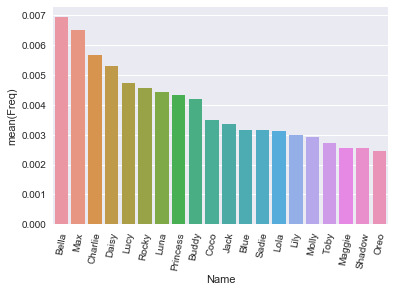

In [7]:
# plot name frequency bar chart for first 20 names

name_df = pd.DataFrame(list(name_dict.items()),columns=['Name','Freq'])
print (name_df.shape)

df_name_sorted=name_df.sort_values(by='Freq',ascending=False).iloc[:20]
s_plot=sns.barplot(x='Name',y='Freq',data=df_name_sorted)
plt.setp(s_plot.get_xticklabels(), rotation=80)
plt.show()

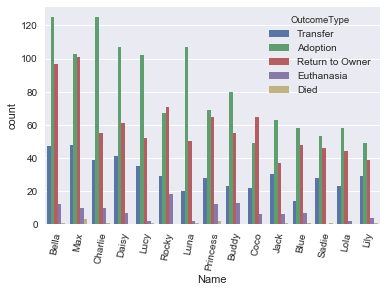

In [8]:
first_x_names = list(df_name_sorted.iloc[:15].Name)
#print first_15_names frequency
first_x_df = animal[animal.Name.isin(first_x_names)]


s_plot=sns.countplot(x='Name',hue='OutcomeType',data=first_x_df.sort_values(by='NameFreq',ascending=False))
plt.setp(s_plot.get_xticklabels(), rotation=80)
plt.show()

Bella seems to be the most popular name in the shelter. Animal with name ‘Charlie’ (3rd popular name) , Daisy (4th), Lucy (5th) or Luna (6th) seems to have a much higher chance to be adopted. Animal with names such as Max, Rocky  or Princess have similar adoption and return rate, and Rocky seems to have the highest euthanasia rate

In [9]:
#convert age to age in days
animal['AgeDays'] = animal['Age'].apply(lambda x:parse_age(x))

animal['DateTime'] = pd.to_datetime(animal['DateTime'])
#generating features from DateTime
animal['year'] = animal['DateTime'].dt.year
animal['month'] = animal['DateTime'].dt.month
animal['hour'] = animal['DateTime'].dt.hour + animal['DateTime'].dt.minute / 60e0
animal['day'] = animal['DateTime'].dt.day
animal['wday'] = animal['DateTime'].dt.dayofweek


In [10]:
#drop some original columns after feature engineering
dropped_col=['AnimalID','Name','Sex','Age','Breed','Color']
animal.drop(dropped_col,axis=1,inplace=True)

In [11]:

#save to file
animal.to_csv('animal_shelter.csv',index=False)

## Step 3: Exploratory Data Analysis

In [12]:
#CHECKPOINT
shelter = pd.read_csv('animal_shelter.csv')
print (shelter.shape)
print (shelter.columns)

(57880, 23)
Index(['OutcomeType', 'IntakeCount', 'DateTime', 'IntakeType', 'IntakeCond',
       'AnimalType', 'BreedGroup', 'IsMix', 'IsMiniature', 'HairType',
       'IsAggressive', 'IsCross', 'ColorGroup', 'AnimalSex', 'Intactness',
       'HasName', 'NameFreq', 'AgeDays', 'year', 'month', 'hour', 'day',
       'wday'],
      dtype='object')


##### 1- Outcome Type

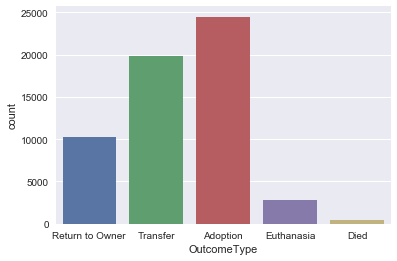

In [13]:
sns.countplot(x='OutcomeType',data=shelter)

In [4]:
print ((shelter.OutcomeType.value_counts() / shelter.shape[0])*100)

Adoption           42.311679
Transfer           34.305460
Return to Owner    17.814444
Euthanasia          4.751209
Died                0.817208
Name: OutcomeType, dtype: float64


As we can see, dataset is imbalanced.

##### 2- Intake Count


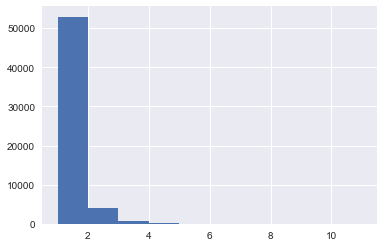

In [27]:
#plot intake count

plt.hist(shelter.IntakeCount)
plt.show()

#majority of animal only enters the shelter once.

c:\Users\anhqu\Miniconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


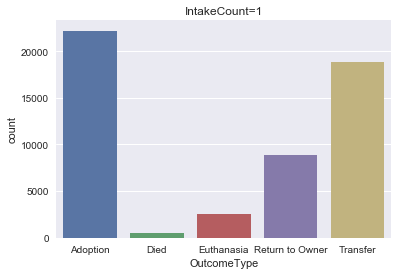

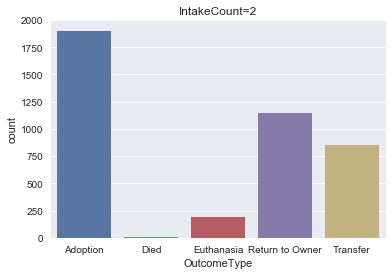

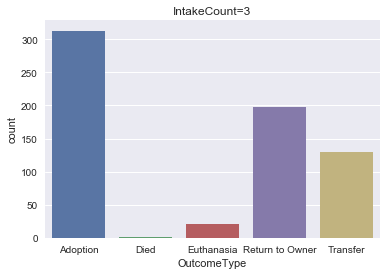

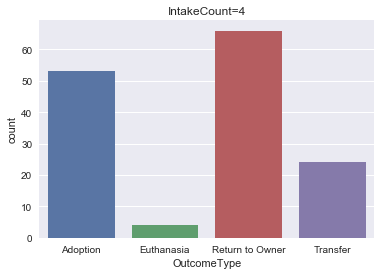

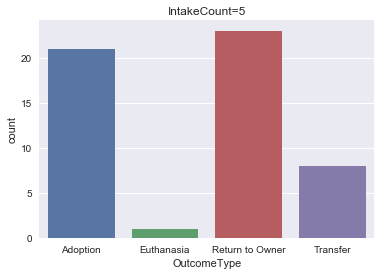

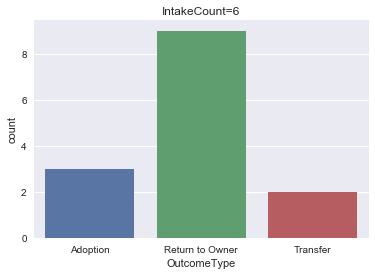

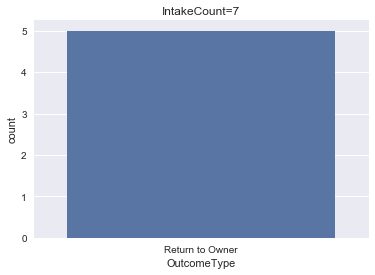

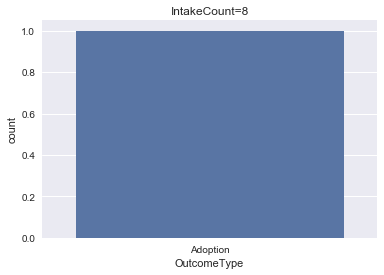

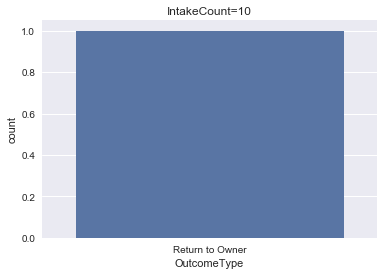

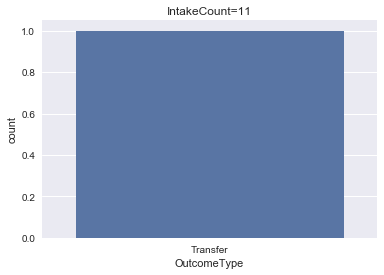

In [28]:

for i in sorted(list(shelter.IntakeCount.unique())):
    s = sns.countplot(x='OutcomeType',data=shelter.sort_values(by='OutcomeType')[shelter.IntakeCount == i])
    plt.title('IntakeCount=' + str(i))
    plt.show()

    # for newcoming animals, they are likely to be adopted or transferred.
    #As intakecount increases,  animals get higher chance to be returned to owner than be adopted.
    # good new is they are not going to 

For new animals, they are more likely to be adopted or transferred. They still have a high chance to be adopted if they return to the shelter within 3 times. For more than 3 times, they are more likely to be returned to owner

##### 3- Intake Type

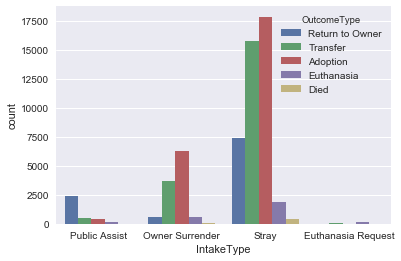

In [29]:
sns.countplot(x='IntakeType',hue='OutcomeType',data=shelter)

# Majority of animals entering the shelter are stray animals, followed by Owner surrender . 
# Not clear outcometype distinction for Owner surrender and stray
#Animals are more likely to be returned to owner when they are found by Public assist (good)

Majority of animals entering the shelter are Stray animals, followed by Owner Surrender. Animals are more likely to be returned to owner if there intake type is Public Assist. 

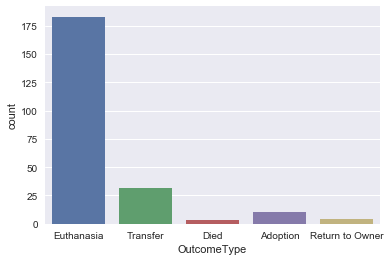

In [30]:
sns.countplot(x='OutcomeType',data=shelter[shelter.IntakeType=='Euthanasia Request'])

A closer look of class label when Intake Type is Euthanasia Request. Well... at least they are not 100% get euthanized when there's an euthanasia request.

##### 4- Intake Condition

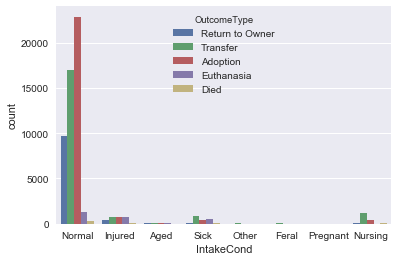

In [31]:
sns.countplot(x='IntakeCond',hue='OutcomeType',data=shelter)

# majority of animal has normal condition

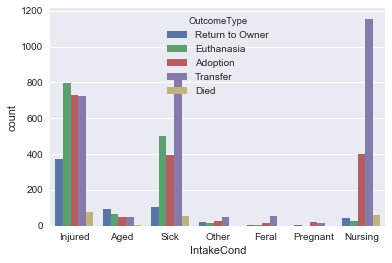

In [7]:
#plot every condition except for normal
sns.countplot(x='IntakeCond',hue='OutcomeType',data=shelter[shelter.IntakeCond!='Normal'])

Sadly, an injured animal gets a higher chance to be put to sleep. One interesting point here is the peak of Transfer outcome for 'nursing' condition.

##### 5- Animal type: Dog and cat

Cats: 42.33241188666206 %
Dogs: 57.66758811333794 %


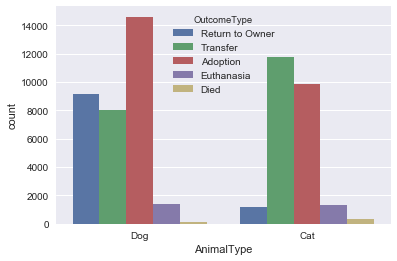

In [9]:
cat = shelter[shelter.AnimalType=='Cat']
dog = shelter[shelter.AnimalType=='Dog']
print ('Cats: {} %'.format(100*cat.shape[0]/shelter.shape[0]))
print ('Dogs: {} %'.format(100*dog.shape[0]/shelter.shape[0]))
sns.countplot(x='AnimalType',hue='OutcomeType',data=shelter)



There are more dogs than cats (58% vs 42%) in the shelter. Dogs are more likely to be returned to owner than cat. Combining with other features, this feature can be a useful to predict ‘Returned to owner’ outcome.
Also, cat are more likely to be transferred and dogs have higher chance to be adopted. 


##### 6- Breed Group

Dog breed


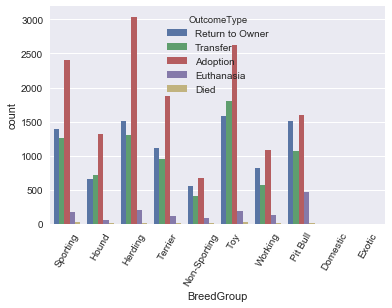

Cat breed


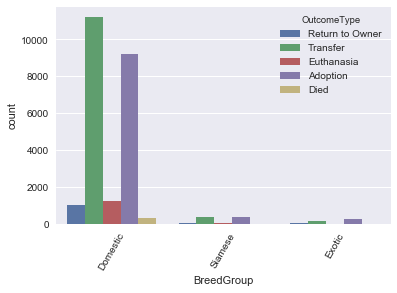

In [14]:
print('Dog breed')
s_plot=sns.countplot(x='BreedGroup',hue='OutcomeType',data=shelter[shelter.AnimalType=='Dog'])
plt.setp(s_plot.get_xticklabels(), rotation=60)
plt.show()
print('Cat breed')
s_plot=sns.countplot(x='BreedGroup',hue='OutcomeType',data=shelter[shelter.AnimalType=='Cat'])
plt.setp(s_plot.get_xticklabels(), rotation=60)
plt.show()

For dogs, the majority of breed group is ‘Herding’. For cats, it is ‘Domestic’ group. All of them have highest probability in adoption, few dog breeds have higher transfer rate than return rate and vice versa, but they don’t differ significantly, except for Pitbull: this group has high chance to be returned to owner, almost as high as Adoption chance. Sadly, Pitbull group has highest chance to be euthanized, comparing to all other groups

##### 7- Color

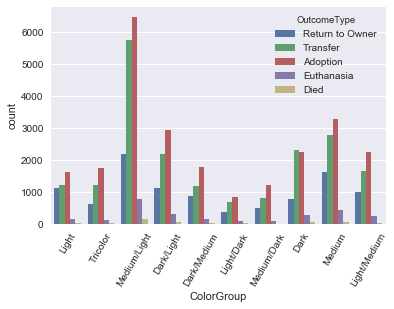

In [39]:
s_plot=sns.countplot(x='ColorGroup',hue='OutcomeType',data=shelter)
plt.setp(s_plot.get_xticklabels(), rotation=60)
plt.show()

#majority of animal has medium/light color

Most animals have medium/light features, and dark colored animal have the same chance to be either transferred or adopted. Same with Breed group attribute, not much information can be drawn from Color group alone

##### 8- Sex and Intactness

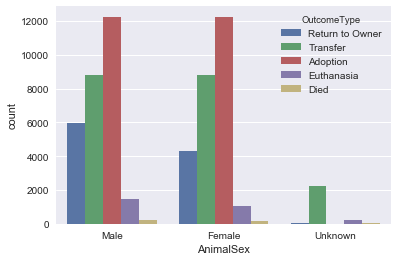

In [31]:
s_plot=sns.countplot(x='AnimalSex',hue='OutcomeType',data=shelter)

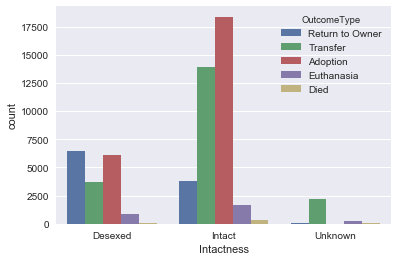

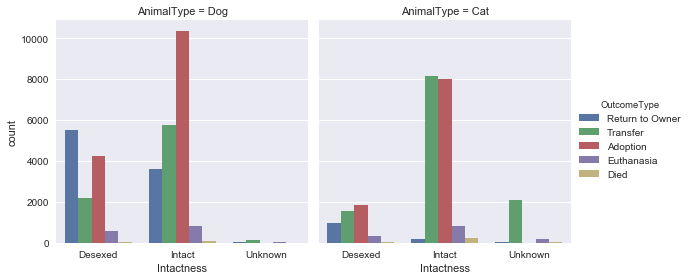

In [41]:
s_plot=sns.countplot(x='Intactness',hue='OutcomeType',data=shelter)
plt.show()

s_plot = sns.factorplot(x='Intactness',hue='OutcomeType',col='AnimalType',kind='count',data=shelter)
plt.show()



Intact animal are more likely to be adopted or transferred. Intact dog are more likely to be adopted, meanwhile intact cats have the same chance to be transferred or adopted. Cat with unknown intactness are more likely to be transferred.

##### 9- Name

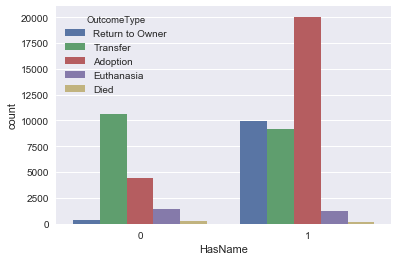

In [42]:
s_plot=sns.countplot(x='HasName',hue='OutcomeType',data=shelter)

# Animal with a name are more likely to be adopted. Also they are more liklely to be returned to owner

Animal with a name are more likely to be adopted. Also they are more likely to be returned to owner than animal with no name. This can be a useful feature to distinguish ‘Return to Owner’ type

##### 10- Age

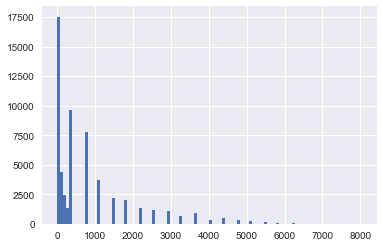

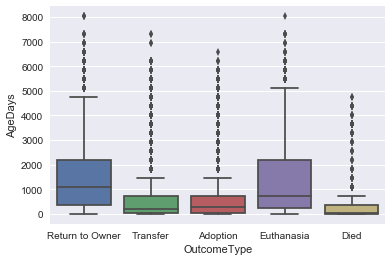

In [18]:
plt.figure()
plt.hist(shelter.AgeDays,100);
plt.show()
# Majority of animal are < 400 days old, or 1 year old

s=sns.boxplot(x='OutcomeType',y='AgeDays',data=shelter)

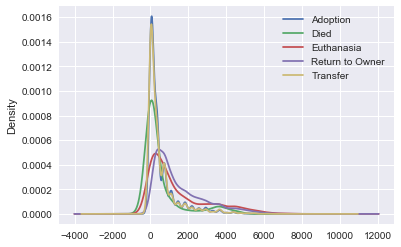

In [45]:
shelter.groupby('OutcomeType').AgeDays.plot(kind='kde')
plt.legend()


Majority of animals are less than 1000 days old (2.7 years old). Based on kernel density estimation (KDE) plot, lots of animal die young (~100 days old). The older the animal, the less likely he/she is adopted or transferred. 

#####  11- DateTime

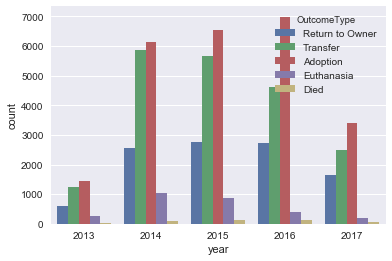

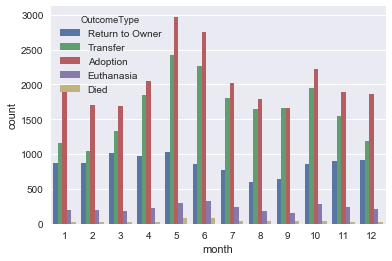

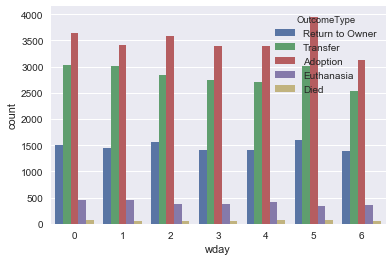

In [96]:
s_plot=sns.countplot(x='year',hue='OutcomeType',data=shelter)
plt.show()
s_plot=sns.countplot(x='month',hue='OutcomeType',data=shelter)
plt.show()
# s_plot=sns.countplot(x='day',hue='OutcomeType',data=shelter)
# plt.show()
s_plot=sns.countplot(x='wday',hue='OutcomeType',data=shelter)
plt.show()
# Shelter receives lots of animal in Summer, especially in May and June. They are more likely to be adopted on these 2 months
# The trend of  outcometype seems to be stable throughout the years, except that fewer animals were euthanized (good)
# 

It’s good to see number of adoption grows (about 500 animals are adopted each year between 2014 and 2016) and number of euthanasia decreases over the year. They are more likely to be adopted in this period as well.

Shelter receives lots of animal in Summer, especially in May and June, and they have higher chance to be adopted. 

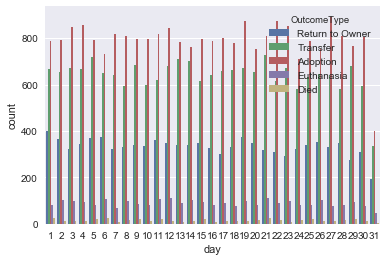

In [34]:
s_plot=sns.countplot(x='day',hue='OutcomeType',data=shelter)
plt.show()


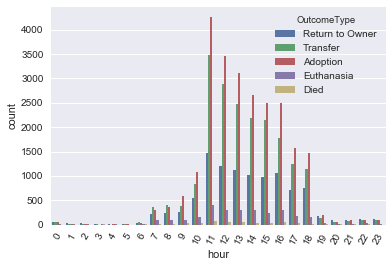

In [40]:
def parse_hour(x):
    for i in range(24):
        if x>=i and x<=i+1:
            return i
hour_temp = shelter[['hour','OutcomeType']].copy()
hour_temp['hour'] = hour_temp['hour'].apply(lambda x: parse_hour(x))
# hour_temp = hour_temp.sort_values(by='hour')
s_plot=sns.countplot(x='hour',hue='OutcomeType',data=hour_temp)
plt.setp(s_plot.get_xticklabels(), rotation=60)
plt.show()

Most of animal enters the shelter in the afternoon, and most busiest hours are between 11 am and 3 pm. More than 8000 animals are adopted if they enter the shelter between 11 am and 1 pm.

### Preprocessing

In [3]:

#CHECKPOINT
shelter = pd.read_csv('animal_shelter.csv')
print (shelter.shape)
print (shelter.columns)


(57880, 23)
Index(['OutcomeType', 'IntakeCount', 'DateTime', 'IntakeType', 'IntakeCond',
       'AnimalType', 'BreedGroup', 'IsMix', 'IsMiniature', 'HairType',
       'IsAggressive', 'IsCross', 'ColorGroup', 'AnimalSex', 'Intactness',
       'HasName', 'NameFreq', 'AgeDays', 'year', 'month', 'hour', 'day',
       'wday'],
      dtype='object')


In [4]:
from scipy.stats import skew

numeric_feats=['IntakeCount','NameFreq','AgeDays']
# Check the skew of all numerical features
skewed_feats = shelter[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)




Skew in numerical features: 



,Skew
IntakeCount,5.257110
NameFreq,3.224125
AgeDays,2.196057


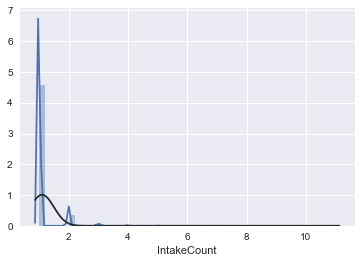

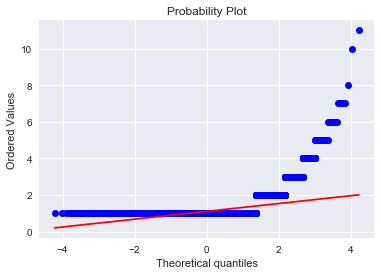

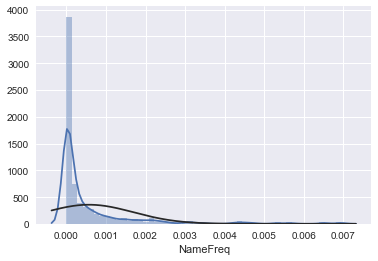

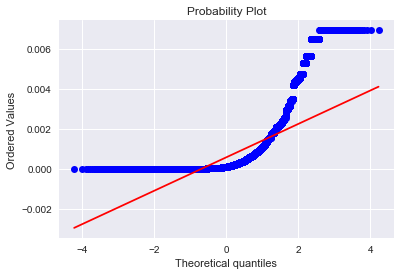

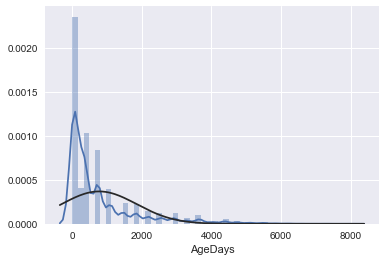

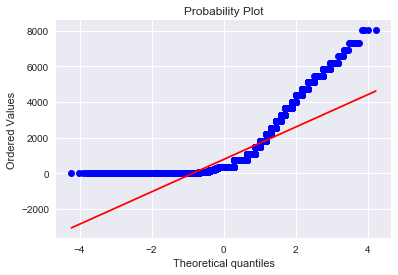

In [19]:
from scipy.stats import norm
from scipy import stats
for each in numeric_feats:
    sns.distplot(shelter[each], fit=norm);
    fig = plt.figure()
    res = stats.probplot(shelter[each], plot=plt)
    plt.show()

Since all 3 numerical features are highly skewed which can lead to heteroscedasticity problem (non-constant variance), box cox transformation will be applied instead of log transformation.

Before doing that, we will apply one-hot encoding to categorical features

In [5]:
# perfome one hot encoding
shelter_onehot = pd.get_dummies(shelter,columns=['IntakeType','IntakeCond','AnimalType','BreedGroup',\
                                                'HairType','ColorGroup','AnimalSex','Intactness','month','day','wday'])
print (shelter_onehot.shape)
print (shelter_onehot.columns)

(57880, 109)
Index(['OutcomeType', 'IntakeCount', 'DateTime', 'IsMix', 'IsMiniature',
       'IsAggressive', 'IsCross', 'HasName', 'NameFreq', 'AgeDays',
       ...
       'day_29', 'day_30', 'day_31', 'wday_0', 'wday_1', 'wday_2', 'wday_3',
       'wday_4', 'wday_5', 'wday_6'],
      dtype='object', length=109)


In [6]:
# print percentage of test set
print ((1.0*shelter_onehot[shelter_onehot.DateTime <='2016-09-01'].shape[0]) / shelter.shape[0])

0.7834312370421562


In [7]:
#splitting train set and test set
from sklearn.utils import shuffle
shelter_onehot.drop('year',axis=1,inplace=True) 
train = shelter_onehot[shelter_onehot.DateTime <='2016-09-01'].copy()
test =  shelter_onehot[shelter_onehot.DateTime > '2016-09-01'].copy()
train.drop('DateTime',axis=1,inplace=True)
test.drop('DateTime',axis=1,inplace=True)

train = shuffle(train)
test = shuffle(test)
print (train.shape)
print (test.shape)

(45345, 107)
(12535, 107)


In [8]:
# box cox  + scaling
from scipy.special import boxcox1p
from sklearn.preprocessing import MinMaxScaler

numeric_feats=['IntakeCount','NameFreq','AgeDays']

def preprocess_numerical(df):      

    scaler = MinMaxScaler()
    #perform log transformation and followed by scaling
    df[numeric_feats] = scaler.fit_transform(boxcox1p(df[numeric_feats],0.32))
    return df

train = preprocess_numerical(train)
test = preprocess_numerical(test)

In [10]:
#export preprocessed data
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

## Step 4: Apply supervised models + Tuning Hyper Parameter

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.dummy import DummyClassifier
%matplotlib inline
%timeit

In [3]:
#checkpoint
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# print train.head()
# print test.head()
def parse_outcome(outcome):
    outcome = outcome.strip()
    if outcome == "Adoption":
        return 0
    if outcome == "Died":
        return 1
    if outcome == "Euthanasia":
        return 2
    if outcome == "Return to Owner":
        return 3
    if outcome == "Transfer":
        return 4

    raise Exception("Unknown outcome type")


y_train = train.OutcomeType.apply(lambda x: parse_outcome(x)).copy()
train.drop('OutcomeType',axis=1,inplace=True)

y_test = test.OutcomeType.apply(lambda x: parse_outcome(x)).copy()
test.drop('OutcomeType',axis=1,inplace=True)

In [13]:
x = train.values
correlation_matrix = np.corrcoef(x.T)

In [14]:
# find which features are highly correlated. Corr coefficient > 0.8 to be consider high.
high_corr = 0.80
count = 0
for i in range(int(correlation_matrix.shape[0])):
    for j in range(i+1,int(correlation_matrix.shape[0])):
        corr = round(correlation_matrix[i,j],5)
        if corr != -1.0 and corr != 1.0 and (corr >=high_corr or corr <= -1*high_corr):
            print ('row: {},col: {}, cor: {}'.format(i,j,corr))
            print ('{} correlates with {}'.format(train.columns[i],train.columns[j]))
            count +=1
print (count)


row: 1,col: 4, cor: -0.81411
IsMix correlates with IsCross
row: 10,col: 12, cor: -0.83216
IntakeType_Owner Surrender correlates with IntakeType_Stray
row: 21,col: 23, cor: 0.94668
AnimalType_Cat correlates with BreedGroup_Domestic
row: 22,col: 23, cor: -0.94668
AnimalType_Dog correlates with BreedGroup_Domestic
row: 23,col: 38, cor: -0.81732
BreedGroup_Domestic correlates with HairType_Unknown
row: 37,col: 38, cor: -0.87856
HairType_Short Hair correlates with HairType_Unknown
row: 50,col: 51, cor: -0.91251
AnimalSex_Female correlates with AnimalSex_Male
row: 53,col: 54, cor: -0.89967
Intactness_Desexed correlates with Intactness_Intact
8


There are few features that are highly correlated (with > 0.8 correlation coefficient), and some of them are: IsMix vs IsCross, AnimalType vs Domestic breed group, Domestic breed group vs Unknown hair type, etc.

Decision trees algorithm is considered due to the nature of this dataset; some features are highly correlated, and there might be redundant attributes or irrelevant features. In order to deal with decision tree’s disadvantages such as: not robust with noise, easy to overfit and low generalization accuracy, decision trees are used as weak learners to build a more robust model. This method is called Ensemble Methods with some famous models such as Random Forest and XGBoost
    

We will prepare some functions to check model performance.

In [70]:
#function to check performance of classifier on train set, and more important, the unseen test set
def check_log_score(clf):   
    pred = clf.predict_proba(train)
    print ("Final log loss on the training data: {:.4f}".format(log_loss(y_train,pred,eps=1e-15)))
    test_pred = clf.predict_proba(test)
    print ("Final log loss on the test data: {:.4f}".format(log_loss(y_test,test_pred,eps=1e-15)))

In [5]:
# function to plot learning curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
 
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring='neg_log_loss',verbose=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [6]:
# function to plot feature importances
def plot_feature_importances(importances,number_of_features):
    columns = train.columns
    indices = np.argsort(importances)[::-1]
    length = number_of_features
    plt.title('Feature Importances')
    plt.bar(range(length),importances[indices[:length]],color='lightblue',align='center')
    plt.xticks(range(length),columns[indices[:length]],rotation=90)
    plt.xlim([-1,length])
    plt.tight_layout()
    plt.show()

In [8]:
from sklearn.metrics import confusion_matrix
# function to plot confusion matrix
def plot_confusion_matrix(clf):
    cm = confusion_matrix(y_test,np.argmax(clf.predict_proba(test),axis=1))
    # cm = 1.0* cm / test.shape[0]
    labels= ["Adoption",'Die','Euthanasia','Return','Transfer']
    sns.heatmap(cm, cmap='Blues',xticklabels=labels, yticklabels=labels,annot=True,fmt=".0f")
    plt.ylabel('True classes')
    plt.xlabel('Predicted classes')

## Naive Benchmark

In [9]:
# BENCHMARK
from sklearn.dummy import DummyClassifier
benchmark_clf = DummyClassifier(strategy='prior',random_state=1)
benchmark_clf.fit(train,y_train)
print ('Basic benchmark -  most frequent label')
check_log_score(benchmark_clf)

Basic benchmark -  most frequent label
Final log loss on the training data: 1.2302
Final log loss on the test data: 1.1971


## Random Forest

In [19]:
# try default random forest
from sklearn.ensemble import RandomForestClassifier
clf_forest = RandomForestClassifier(random_state=1).fit(train,y_train)



In [20]:
check_log_score(clf_forest)

Final log loss on the training data: 0.2000
Final log loss on the test data: 2.5151


[learning_curve] Training set sizes: [ 3022  9824 16625 23427 30229]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.9s finished
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


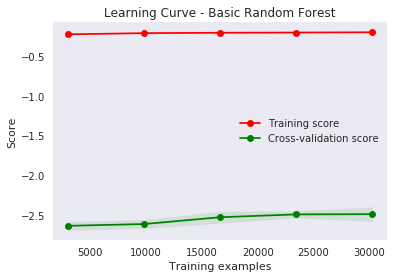

In [21]:
plot_learning_curve(clf_forest, 'Learning Curve - Basic Random Forest', train, y_train, n_jobs=-1)
plt.show()

#overfitting

Default Random Forest shows sign of overfitting when training score is steadily low but cross-validation score is very high in comparison, thus create a distinctive gap indicating overfitting. 

The model will be tuned using grid search to find the best combination of hyper parameters and then cross-validated with 5 stratified CV folds, which provides an unbiased estimate of how good the model and its performance at runtime

In [11]:
# tuning Random Forest
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import randint as sp_randint

cv = StratifiedShuffleSplit(n_splits=5,random_state=1)
params = {
           'n_estimators': [100,500,1000],
            'max_features':['auto','log2'],
            'max_depth': [10,15,20,30]
        }
clf = RandomForestClassifier(random_state=1,oob_score=True)
grid = GridSearchCV(clf,params,scoring='neg_log_loss',\
                          n_jobs=-1,cv=cv,verbose=True)

In [68]:
grid_fit_rf = grid.fit(train,y_train)
clf_best_forest = grid_fit_rf.best_estimator_
# print (clf_best_forest.get_params())


In [22]:

#Best parameters for random forest is n_estimators=1000, max_depth =20, max features = auto
clf_best_rf = RandomForestClassifier(random_state=1,max_features='auto',\
                                     n_estimators=1000,max_depth=20,n_jobs=-1).fit(train,y_train)


In [23]:
check_log_score(clf_best_rf)

Final log loss on the training data: 0.5214
Final log loss on the test data: 0.8520


Grid search results in 1000 trees, ‘auto’ max features and max depth of 20 as best values for the model. There is a huge improvement in cross-validation score comparing to the default Random Forest model and the model generalizes the dataset better.

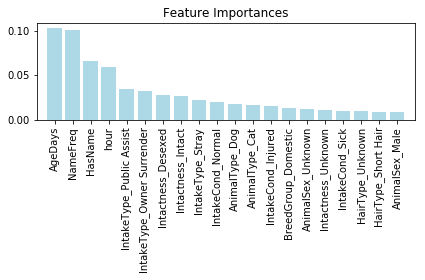

In [31]:
plot_feature_importances(clf_best_rf.feature_importances_,20)

AgeDays, NameFreq, HasName and hour are 5 most important features. It turns out that breed or color are not even in top 10 most important features

[learning_curve] Training set sizes: [ 3022  9824 16625 23427 30229]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   57.4s finished


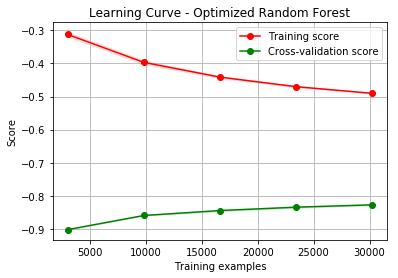

In [32]:
plot_learning_curve(clf_best_rf, 'Learning Curve - Optimized Random Forest', train, y_train,  n_jobs=-1)
plt.show()

## XGBoost

Similar to Random Forest, same process will be used to pick the best model using XGBoost

One useful factor about XGBoost library is XGBoost model can evaluate and report on the performance on a test set during training. Thus training can be stopped once there is no improvement seen on the validation. Here is the code snippet used to train the model using default XGBoost with early stopping


In [15]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.dummy import DummyClassifier
# randomized search and stuff
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from xgboost import plot_importance
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
%timeit

In [ ]:
clf_xgb = XGBClassifier(objective='multi:softprob',n_jobs=-1,seed=1)
clf_xgb = clf_xgb.fit(train,y_train,eval_metric='mlogloss',\
                     early_stopping_rounds=10,\
                      eval_set = [(test,y_test)],verbose=True)
# plot_importance(clf_xgb)
# plt.show()

In [11]:
check_log_score(clf_xgb)

Final log loss on the training data: 0.8558
Final log loss on the test data: 0.8572


[learning_curve] Training set sizes: [ 3022  9824 16625 23427 30229]


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  1.3min finished


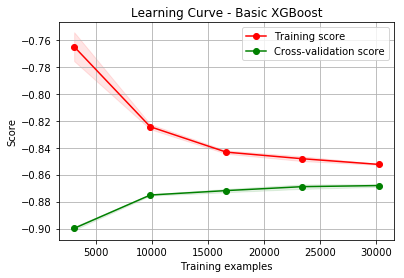

In [37]:
plot_learning_curve(clf_xgb, 'Learning Curve - Basic XGBoost', train, y_train, n_jobs=-1)
plt.show()

In [56]:
#Tuning XGBoost

cv = StratifiedShuffleSplit(n_splits=5,random_state=1)

# Params space for Grid search. I didn't grid search the whole space, since it's time consuming 
# First grid search with n_estimators and learning_rate -> ends up with 400 and 0.07
# Using these values for second search with max depth -> max_depth = 8
# Third grid search for colsample_bytree and reg_lambda -> 0.4 for colsample and 1 reglambda
params = {
           'n_estimators': [200,400,800,1000],
            "learning_rate": [0.03,0.07,0.1],
            "max_depth": [2,4,6,8],          
            "objective":['multi:softprob'],
            "colsample_bytree": [0.4,0.6,0.8,1],
            'reg_lambda':[0.1,0.3,1,3]
           
        }

clf_xgb = XGBClassifier()
xgb_grid = GridSearchCV(clf_xgb,params,scoring='neg_log_loss',\
                          n_jobs=-1,cv=cv,verbose=True)

In [57]:
xgb_grid_fit = xgb_grid.fit(train,y_train)
best_xgb = xgb_grid_fit.best_estimator_
print (best_xgb.get_params())

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 111.4min finished


{'reg_alpha': 0, 'n_jobs': -1, 'colsample_bytree': 0.4, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.07, 'missing': None, 'max_delta_step': 0, 'nthread': None, 'base_score': 0.5, 'n_estimators': 400, 'subsample': 1, 'reg_lambda': 1, 'random_state': 0, 'min_child_weight': 1, 'objective': 'multi:softprob', 'seed': None, 'max_depth': 8, 'gamma': 0, 'booster': 'gbtree'}


In [59]:
best_xgb = best_xgb.fit(train,y_train,eval_metric='mlogloss',\
                     early_stopping_rounds=10,\
                      eval_set = [(test,y_test)],verbose=True)
check_log_score(best_xgb)

[0]	validation_0-mlogloss:1.55854
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.50452
[2]	validation_0-mlogloss:1.45929
[3]	validation_0-mlogloss:1.42442
[4]	validation_0-mlogloss:1.38339
[5]	validation_0-mlogloss:1.34892
[6]	validation_0-mlogloss:1.31359
[7]	validation_0-mlogloss:1.28651
[8]	validation_0-mlogloss:1.26371
[9]	validation_0-mlogloss:1.24416
[10]	validation_0-mlogloss:1.21924
[11]	validation_0-mlogloss:1.19877
[12]	validation_0-mlogloss:1.17833
[13]	validation_0-mlogloss:1.15649
[14]	validation_0-mlogloss:1.13892
[15]	validation_0-mlogloss:1.12084
[16]	validation_0-mlogloss:1.10579
[17]	validation_0-mlogloss:1.09135
[18]	validation_0-mlogloss:1.07699
[19]	validation_0-mlogloss:1.06459
[20]	validation_0-mlogloss:1.05181
[21]	validation_0-mlogloss:1.03983
[22]	validation_0-mlogloss:1.02937
[23]	validation_0-mlogloss:1.01954
[24]	validation_0-mlogloss:1.00998
[25]	validation_0-mlogloss:1.00163
[26]	validation_0-mlogloss:0.99

Log loss on test score is only a little bit better than XGBoost with default parameters.

[learning_curve] Training set sizes: [ 3022  9824 16625 23427 30229]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  7.3min finished


<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

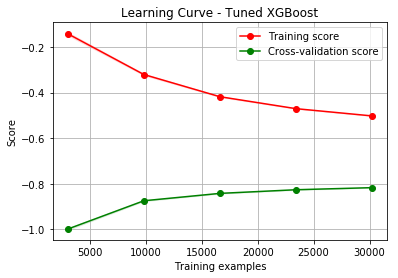

In [60]:
plot_learning_curve(best_xgb,'Learning Curve - Tuned XGBoost', train, y_train, n_jobs=-1)

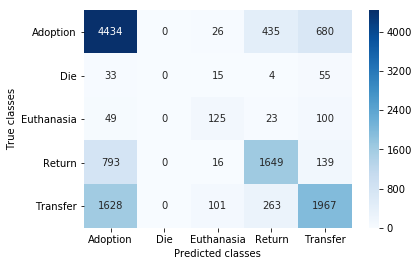

In [67]:
plot_confusion_matrix(best_xgb)

We can take a closer look at each of the label prediction by calculating its precision and recall
-	Adoption: 63.9% precision, 79.5% recall. This is high compared to other labels. The model did a good job on predicting adopted animals. 
-	Die: 0% precision, 0% recall. The model did the worst on predicting this label. Lots of ‘Die’ animals are misclassified as ‘Transfer’ and ‘Adoption’. There are only 8% animals that die in the dataset, and this can be the reason for poor prediction on Die animal 
-	Euthanasia: 44.2% precision, 42% recall.  The model also did poorly on this class. 34% of ‘Euthanasia’ animals are misclassified as ‘Transfer’
-	Return To Owner: 69.4% precision, 63.4% recall. This is the second best label the model predicted. Lots of ‘Return to owner’ animals (30%) are misclassified as ‘Adoption’
-	Transfer: 66.9% precision, 49.68% recall. The model has the hard time distinguishing between ‘Transfer’ and ‘Adoption’, as 41% of ‘Transfer’ are misclassified as ‘Adoption’ 


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


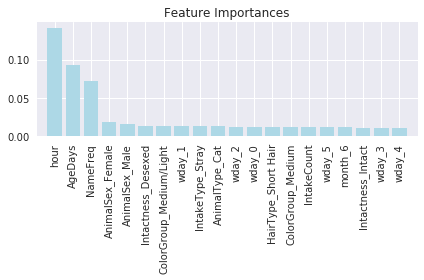

In [34]:
plot_feature_importances(best_xgb.feature_importances_,20)

Intake hour, name frequency, age in days, animal sex and color (medium/light) are five most important features. Surprisingly, features I thought that could make an impact such as aggressiveness, animal type or breed are less important.

### Other supervised model

#### Logistic Regression Classification

In [66]:
from sklearn.linear_model import LogisticRegression


In [68]:
cv = StratifiedShuffleSplit(n_splits=5,random_state=1)
params = {
           'C': [0.01,0.03,0.1,0.3,1],
            'solver': ['newton-cg']
        }


clf = LogisticRegression(random_state=1,multi_class='multinomial')
grid = GridSearchCV(clf,params,scoring='neg_log_loss',\
                          n_jobs=-1,cv=cv,verbose=True)
linear_grid = grid.fit(train,y_train)
best_linear = linear_grid.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:  1.8min remaining:   27.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.1min finished


In [71]:
print(best_linear.get_params())
check_log_score(best_linear)

{'C': 0.3, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 1, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Final log loss on the training data: 0.8991
Final log loss on the test data: 0.9022


####  Extra trees

In [75]:
# Extra trees
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

cv = StratifiedShuffleSplit(n_splits=5,random_state=1)
params = {
                 "n_estimators": [250,300,350],
                "max_features":[0.55,0.6,0.65,0.7],
                "max_depth":[10]
             }

clf = ExtraTreesClassifier(random_state=1)
grid = GridSearchCV(clf,params,scoring='neg_log_loss',\
                          n_jobs=-1,cv=cv,verbose=True)

In [76]:
extra_grid = grid.fit(train,y_train)
best_extra = extra_grid.best_estimator_
print(best_extra.get_params())

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.9min finished


{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 0.65, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': 1, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


In [77]:
check_log_score(best_extra)

Final log loss on the training data: 0.7956
Final log loss on the test data: 0.8665


## Comparison: Log loss score (on test set)

- Random Forest: 0.8520
- XGBoost: 0.8409
- Logistic Regression: 0.9022
- Extra Tree Classifier: 0.8665

XGBoost is the best model for this dataset

## Step 5: Ensemble Stacking

Credits to a detailed blog about ensemble stacking <a href='https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python'>here</a>

Stacking model will have 2 learning levels. The first level including 3 best tuned models from above: xgboost, random classifier and extra tree classifier. Cross validation of 5 folds is used for each models and the predictions from validation sets will become the new training set for the second levels. Or in another way the ouput of first level will be the input for second level. 

Since we are using log loss metric, outputs of first level will be the estimate probability of 5 class labels instead of the class label itself

For second level, the 'meta model' to make the final prediction will be xgboost.


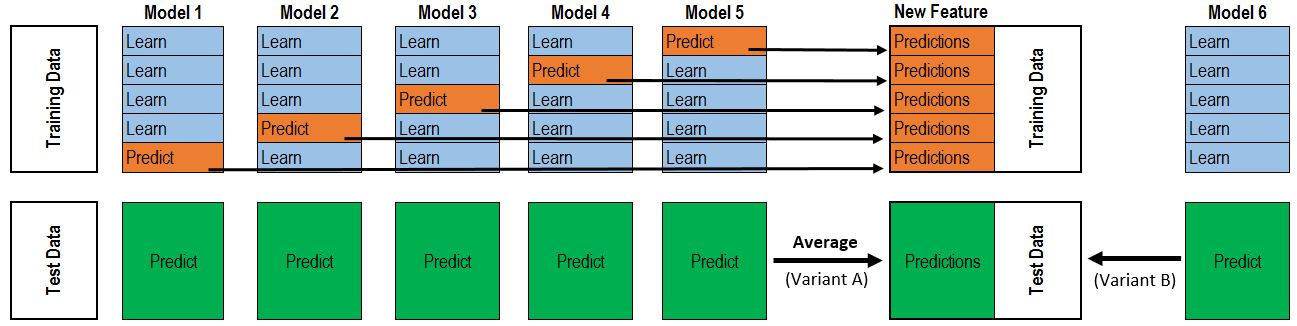

In [73]:
from sklearn.model_selection import KFold
ntrain = train.shape[0]
ntest = test.shape[0]
num_of_labels = 5

class SklearnWrapper(object):
    def __init__(self, clf, seed=1, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict_proba(self, x):
        return self.clf.predict_proba(x)
    def predict(self,x):
        return self.clf.predict(x)

class XgbWrapper(object):
    def __init__(self, clf,seed=1, params=None):
        params['seed']=seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train,y_train,eval_metric='mlogloss')

    def predict_proba(self, x):
        return self.clf.predict_proba(x)
    def predict(self,x):
        return self.clf.predict(x)

NFOLDS=5
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=1)

# creating matrices for sklearn
x_train = np.array(train)
x_test = np.array(test)

def get_oof_proba(clf):  
    oof_train = np.zeros((ntrain,num_of_labels))
    oof_test = np.zeros((ntest,num_of_labels))
    oof_test_skf = np.empty((NFOLDS, ntest,num_of_labels))
    i=0
    for (train_index, test_index) in kf.split(train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict_proba(x_te)
        oof_test_skf[i, :] = clf.predict_proba(x_test)
        i+=1        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train, oof_test

def get_oof(clf):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    i=0
    for (train_index, test_index) in kf.split(train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        i+=1        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [74]:
rf_params={
    'max_features':'auto',
    'n_estimators':1000,
    'max_depth':20,
    'n_jobs':-1
    
}

xgb_params={

 'colsample_bylevel': 1,
 'colsample_bytree': 0.4,
 'gamma': 0,
 'learning_rate': 0.07,
 'max_depth': 8,
 'min_child_weight': 1,
 'n_estimators': 400,
 'objective': 'multi:softprob',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
    'n_jobs':-1
}

extree_params = {
     "n_estimators": 250,
    "max_features":0.65,
    "max_depth":10,
    'n_jobs':-1
}


In [75]:
xgb = XgbWrapper(clf=XGBClassifier,seed=1,params=xgb_params)
rf= SklearnWrapper(clf=RandomForestClassifier, seed=1, params=rf_params)
extree = SklearnWrapper(clf=ExtraTreesClassifier,seed=1,params=extree_params)


In [76]:
xg_oof_train,xg_oof_test = get_oof_proba(xgb)
rf_oof_train,rf_oof_test = get_oof_proba(rf)
extree_oof_train,extree_oof_test = get_oof_proba(extree)

In [25]:
#save to csv file
# np.savetxt('xg_oof_train.out',xg_oof_train,delimiter=',')
# np.savetxt('xg_oof_test.out',xg_oof_test,delimiter=',')
# np.savetxt('rf_oof_train.out',rf_oof_train,delimiter=',')
# np.savetxt('rf_oof_test.out',rf_oof_test,delimiter=',')
# np.savetxt('extree_oof_train.out',extree_oof_train,delimiter=',')
# np.savetxt('extree_oof_test.out',extree_oof_test,delimiter=',')

In [77]:

x_train = np.concatenate((xg_oof_train,rf_oof_train,extree_oof_train),axis=1)
x_test = np.concatenate((xg_oof_test,rf_oof_test,extree_oof_test),axis=1)
print (x_train.shape)
print(x_test.shape)

(45345, 15)
(12535, 15)


In [ ]:
# try simple xgboost
xgb_stack = XGBClassifier(objective='multi:softprob',n_jobs=-1,seed=1)
xgb_stack = xgb_stack.fit(x_train,y_train,eval_metric='mlogloss',\
                     early_stopping_rounds=10,\
                      eval_set = [(x_test,y_test)],verbose=True)

In [79]:
def check_log_score_stack(clf,x_train,y_train,x_test,y_test):   
    pred = clf.predict_proba(x_train)
    print ("Final log loss on the training data: {:.4f}".format(log_loss(y_train,pred,eps=1e-15)))
    test_pred = clf.predict_proba(x_test)
    print ("Final log loss on the test data: {:.4f}".format(log_loss(y_test,test_pred,eps=1e-15)))

In [80]:
check_log_score_stack(xgb_stack,x_train,y_train,x_test,y_test)

Final log loss on the training data: 0.7721
Final log loss on the test data: 0.8463


In [82]:
#Tuning XGBoost

cv = StratifiedShuffleSplit(n_splits=5,random_state=1)
params = {
           'n_estimators': [200],
            "learning_rate": [0.03,0.05,0.07],
            "max_depth": [4],          
            "objective":['multi:softprob'],
            "colsample_bytree": [0.8,1],          
        }

clf_xgb = XGBClassifier(seed=1,n_jobs=-1)
xgb_grid = GridSearchCV(clf_xgb,params,scoring='neg_log_loss',\
                          n_jobs=-1,cv=cv,verbose=True)

In [84]:
xgb_grid_fit = xgb_grid.fit(x_train,y_train)
best_xgb = xgb_grid_fit.best_estimator_
print (best_xgb.get_params())

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.4min finished


{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.07, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1, 'missing': None, 'n_estimators': 200, 'n_jobs': -1, 'nthread': None, 'objective': 'multi:softprob', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 1, 'silent': True, 'subsample': 1}


In [85]:
best_xgb = best_xgb.fit(x_train,y_train,eval_metric='mlogloss',\
                     early_stopping_rounds=10,\
                      eval_set = [(x_test,y_test)],verbose=True)

[0]	validation_0-mlogloss:1.53928
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.47856
[2]	validation_0-mlogloss:1.42534
[3]	validation_0-mlogloss:1.37788
[4]	validation_0-mlogloss:1.33543
[5]	validation_0-mlogloss:1.29732
[6]	validation_0-mlogloss:1.26287
[7]	validation_0-mlogloss:1.23153
[8]	validation_0-mlogloss:1.2031
[9]	validation_0-mlogloss:1.17725
[10]	validation_0-mlogloss:1.15348
[11]	validation_0-mlogloss:1.13186
[12]	validation_0-mlogloss:1.11187
[13]	validation_0-mlogloss:1.09354
[14]	validation_0-mlogloss:1.07664
[15]	validation_0-mlogloss:1.06106
[16]	validation_0-mlogloss:1.04678
[17]	validation_0-mlogloss:1.03343
[18]	validation_0-mlogloss:1.02113
[19]	validation_0-mlogloss:1.00982
[20]	validation_0-mlogloss:0.999274
[21]	validation_0-mlogloss:0.989425
[22]	validation_0-mlogloss:0.980381
[23]	validation_0-mlogloss:0.97199
[24]	validation_0-mlogloss:0.964216
[25]	validation_0-mlogloss:0.956976
[26]	validation_0-mlogloss:

In [86]:
check_log_score_stack(best_xgb,x_train,y_train,x_test,y_test)

Final log loss on the training data: 0.7570
Final log loss on the test data: 0.8474


Sadly there's not much improvement for tuned xgboost model compared to the xgboost with default hyper parameters (0.8463) and xgboost from step 4.

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


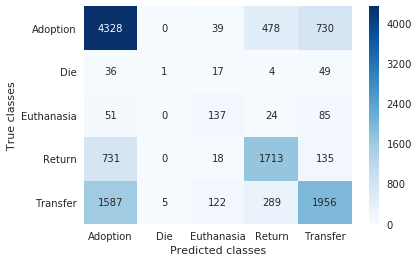

In [87]:
cm = confusion_matrix(y_test,np.argmax(best_xgb.predict_proba(x_test),axis=1))
# cm = 1.0* cm / test.shape[0]
labels= ["Adoption",'Die','Euthanasia','Return','Transfer']
sns.heatmap(cm, cmap='Blues',xticklabels=labels, yticklabels=labels,annot=True,fmt=".0f")
plt.ylabel('True classes')
plt.xlabel('Predicted classes')

This matrix is still similar to the XGBoost confusion matrix above. Adoption is usually predicted accurately, followed by Return-To-Owner. However this is not a good model to predict other labels such as Transfer, Euthanasia or Die.

# Final thought and Improvement

Some interesting aspects of the project are: doing feature engineering and see how each features affect the outcome during EDA. Unfortunately, some of the features which take lots of time to generate, such as breed and color, are not important in predicting the outcomes. Some features that are thought to be irrelevant, such as intake hour and name frequency, are important.

Besides feature engineering, another difficult task is tuning XGBoost to get the best result. Initially a randomized search is performed on large hyper parameters but the model is overfitting and log loss score on test set is just a little better than the default XGBoost. The best model is then built with few parameters tuned one at a time using grid search, iteratively. This task is very time-consuming, thus I have to run it on Amazon Web Service EC2 Instance.

The final model is helpful to predict Adoption and Return-to-owner label, but it did poorly on predicting other labels, therefore it can only be used in a limited setting. 

Even though several methods have been used (some of them are not included in this paper due to poor results such as SVM, different model choices for stacking ...), log loss score seems to be above 0.8. All models seem to have a hard time predicting Transfer class, probably because there is no feature good enough to distinguish this class. We can do more research on the transfer process of animal shelter so we can choose to either get more data and/or generate better features.

Another way to improve prediction power that I didn't have time to implement is to add more level to ensemble stacking. Also, neural network with 2 or 3 hidden layers can be helpful, as hopefully those layers can capture characteristics of labels that are hard to predict.  